# ZKsync data exploration - Swaps

#### [Maria Silva](https://github.com/misilva73), July 2024

This notebook looks into swap events for ZKsync over almost 1 year. We use one main source of data - transaction logs. We also load block data to extract timestamps. This notebook should be an example of interacting and processing our [ZKsync public datasets](https://data.zksync.dev).

## Import packages

In [1]:
import os
import time
import pandas as pd
import polars as pl
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_colwidth', 100)

In [3]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

Note that these are support functions defined in the `src` folder:

In [4]:
from plot_utils import get_plotly_layout, colors, update_plotly_layout_in_place
from utils import events_dict

width, height = 800, 450

Sometimes, plotly takes some time to load Mathjax library, which messes with the pdf saves. This next cell is only here to save a garbage plot and guarantee that, for the actual final plots, the library is already loaded.

In [5]:
fig=px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.write_image("some_figure.pdf", format="pdf")
time.sleep(2)
os.remove("some_figure.pdf")

##  Load Polars DataFrames

In [6]:
# Set directory paths
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots", "swaps_example"))

# Set block limits
block_start = 56_1367 # starting on April 1st to ignore weird blocks during era launch
block_end = 29_710_983

In [7]:
# Load blocks data
blocks_path = os.path.join(data_dir, "blocks", "blocks_*.parquet")
blocks_lazy_df = (
    pl.scan_parquet(blocks_path)
    .filter(pl.col("number").is_between(block_start, block_end))
    .with_columns(pl.from_epoch("timestamp", time_unit="s"))
    .with_columns(pl.col("timestamp").cast(pl.Date).alias("day"))
    .sort("timestamp")
)
blocks_lazy_df.schema

OrderedDict([('hash', String),
             ('parentHash', String),
             ('sha3Uncles', String),
             ('miner', String),
             ('stateRoot', String),
             ('transactionsRoot', String),
             ('receiptsRoot', String),
             ('number', Int64),
             ('l1BatchNumber', String),
             ('gasUsed', Int64),
             ('gasLimit', Int64),
             ('baseFeePerGas', Int64),
             ('extraData', String),
             ('logsBloom', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('l1BatchTimestamp', String),
             ('difficulty', Int64),
             ('totalDifficulty', Int64),
             ('sealFields', List(Null)),
             ('uncles', List(Null)),
             ('size', Int64),
             ('mixHash', String),
             ('nonce', String),
             ('day', Date)])

In [8]:
# Create temp df to join timestamps and date
temp_blocks_df = (
    blocks_lazy_df.select(pl.col("number"), pl.col("timestamp"), pl.col("day"))
)

# Load logs data
logs_path = os.path.join(data_dir, "logs", "logs_*.parquet")
logs_lazy_df = (
    pl.scan_parquet(logs_path)
    .filter(pl.col("blockNumber").is_between(block_start, block_end))
    .join(temp_blocks_df, left_on="blockNumber", right_on="number")
)
logs_lazy_df.schema

OrderedDict([('address', String),
             ('blockHash', String),
             ('blockNumber', Int64),
             ('data', String),
             ('l1BatchNumber', String),
             ('logIndex', Int64),
             ('logType', Null),
             ('removed', Boolean),
             ('transactionHash', String),
             ('transactionIndex', Int64),
             ('transactionLogIndex', String),
             ('topics_0', String),
             ('topics_1', String),
             ('topics_2', String),
             ('topics_3', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('day', Date)])

## Process dataset of swap events

Swap events can be filtered by looking at the right event hash (defined below) and have the following topics and data:

![](../plots/swaps_example/SwapEvent.png)

We can process the topics and the data to extract all relevant fields. Note that we are converting the amounts from the data field into strings because they are 256-bit integers and Polars does not have integers larger than 64-bit.

In [9]:
swap_event_hash = "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822"

swap_lazy_df = (
    logs_lazy_df
    .filter(pl.col('topics_0').str.to_lowercase().eq(swap_event_hash))
    .select([
        pl.col('timestamp'),
        pl.col('day'),
        pl.col('blockNumber'),
        pl.col('transactionHash'),
        pl.col('logIndex'),
        pl.col('address').str.to_lowercase().alias('contract_address'),
        pl.format("0x{}", pl.col('topics_1').str.slice(-40)).alias('sender'),
        pl.format("0x{}", pl.col('topics_2').str.slice(-40)).alias('receiver'),
        pl.col('data').str.slice(2, 64).map_elements(lambda x: str(int(x, 16)), return_dtype=pl.String).alias('amount0_in'),
        pl.col('data').str.slice(2+64, 64).map_elements(lambda x: str(int(x, 16)), return_dtype=pl.String).alias('amount1_in'),
        pl.col('data').str.slice(2+2*64, 64).map_elements(lambda x: str(int(x, 16)), return_dtype=pl.String).alias('amount0_out'),
        pl.col('data').str.slice(2+3*64, 64).map_elements(lambda x: str(int(x, 16)), return_dtype=pl.String).alias('amount1_out'),
    ])
)

swap_lazy_df.schema

OrderedDict([('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('day', Date),
             ('blockNumber', Int64),
             ('transactionHash', String),
             ('logIndex', Int64),
             ('contract_address', String),
             ('sender', String),
             ('receiver', String),
             ('amount0_in', String),
             ('amount1_in', String),
             ('amount0_out', String),
             ('amount1_out', String)])

In [10]:
(swap_lazy_df.limit(5).collect(streaming=True).to_pandas())

,timestamp,day,blockNumber,transactionHash,logIndex,contract_address,sender,receiver,amount0_in,amount1_in,amount0_out,amount1_out
0,2023-07-31 06:11:24,2023-07-31,10000000,0xc9eca17d58773cbc98de725fbf4998fa8aa852f02f2712e97d0126bb8190778b,20,0xd0ce094412898760c2a5e37abec39b0e785b45ae,0xbe7d1fd1f6748bbdefc4fbacafbb11c6fc506d1d,0xd575491bd9293b6d49a87f3d0b9ce7cd75719039,0,5456000000000000,10149673,0
1,2023-07-31 06:11:24,2023-07-31,10000000,0x7757cea9efe561077ed9ae0f3015178ba0a1cbc0ab7bc25291e074e4885ea232,42,0x7642e38867860d4512fcce1116e2fb539c5cdd21,0xc02502cfe2ef70581de8b90c5de9db5c38709d6c,0xa269031037b4d5fa3f771c401d19e57def6cb491,0,7639000000000000,14264810,0
2,2023-07-31 06:11:24,2023-07-31,10000000,0xb879308228257d4afa241522e5ea9794cd1e333871f75548759707459231ae23,68,0x80115c708e12edd42e504c1cd52aea96c547c05c,0x2da10a1e27bf85cedd8ffb1abbe97e53391c0295,0xd6723f9ed079abc688e9286cd1df3ffaa79dcd46,0,14410000000000,26843,0
3,2023-07-31 06:11:24,2023-07-31,10000000,0xb879308228257d4afa241522e5ea9794cd1e333871f75548759707459231ae23,70,0xd6723f9ed079abc688e9286cd1df3ffaa79dcd46,0x2da10a1e27bf85cedd8ffb1abbe97e53391c0295,0x6f7d4bceedc38c57f37cd99c25738869cb392f0e,26843,0,0,142491984803162001
4,2023-07-31 06:11:24,2023-07-31,10000000,0x038d0ec5dd8b82398ff493b5577d6a386af4d1949b62a259b9fe2e23826fb60c,131,0x4b747b1f9dbae8c55b007817553b49acb360812f,0xbe7d1fd1f6748bbdefc4fbacafbb11c6fc506d1d,0x94f7873fed9f891ded6c586f85f4e4338e8d5366,0,98370434186366868580,10543618,0


## Daily swaps

In [11]:
day_swaps_df = (
    swap_lazy_df
    .group_by("day")
    .agg(pl.len().alias("swap_count"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values("day")
)
day_swaps_df.head()

,day,swap_count
28,2023-04-01,102644
323,2023-04-02,128206
113,2023-04-03,139163
118,2023-04-04,118838
91,2023-04-05,95611


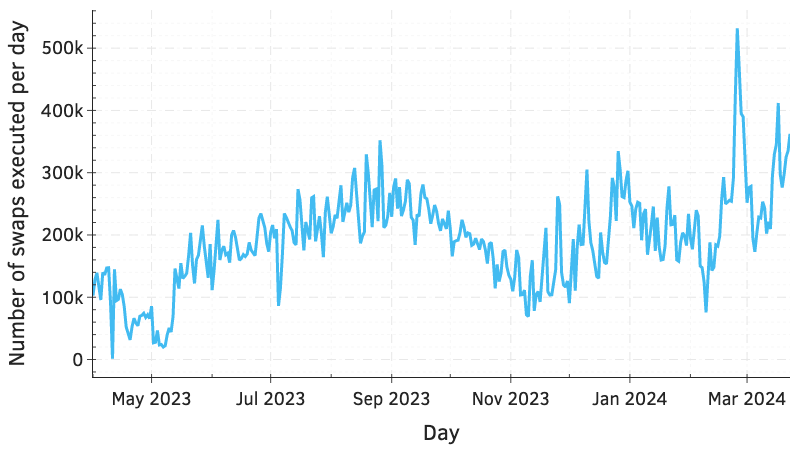

In [12]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=day_swaps_df['day'][:-1], 
    y=day_swaps_df['swap_count'][:-1], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", yaxis_title="Number of swaps executed per day")

fig.write_image(os.path.join(plots_dir,'swaps-per-day.pdf'))
fig.show('png')

In [13]:
day_swaps_df["swap_count"].agg(["mean", "median", "min", "max", "std"])

mean      192009.114206
median    193322.000000
min            3.000000
max       531819.000000
std        75935.142567
Name: swap_count, dtype: float64

## Top emitters

We can see which pool/contract was involved in the swap by looking at the contract address that emitted the event. Note that we will merge the event data with a mapping between contract addresses and contract names we provide in the file `contract_mapping.csv`.

In [14]:
contract_map_file =  os.path.join(data_dir, "contract_mapping.csv")
contract_map_df = pd.read_csv(contract_map_file)
contract_map_df.head()

,name,symbol,decimals,l2Address,l1Address
0,Ether,ETH,18,0x000000000000000000000000000000000000800a,0x0000000000000000000000000000000000000000
1,ChainLink Token,LINK,18,0x082fade8b84b18c441d506e1d3a43a387cc59d20,0x514910771af9ca656af840dff83e8264ecf986ca
2,Wrapped BTC,WBTC,8,0xbbeb516fb02a01611cbbe0453fe3c580d7281011,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
3,Matic Token,MATIC,18,0x770e221ec6f3e8a2e2e168399bb3aa56a63e397d,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0
4,Uniswap,UNI,18,0x1c6f53185061d7cc387e481c350ad00c2c876f3e,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984


In [15]:
hash_emitters_df = (
    swap_lazy_df
    .group_by("contract_address")
    .agg(pl.len().alias("swap_count"))
    .collect(streaming=True)
    .to_pandas()
    .merge(contract_map_df[["l2Address", "name", "symbol"]], how="left", left_on="contract_address", right_on="l2Address")
    .fillna({"name":"Unknown", "symbol":"Unknown"})
    .drop(columns=["l2Address"])
    .sort_values("swap_count", ascending=False)
)
hash_emitters_df["swap_perc"] = hash_emitters_df["swap_count"]/hash_emitters_df["swap_count"].sum()

In [16]:
hash_emitters_df.head(10)

,contract_address,swap_count,name,symbol,swap_perc
2407,0x80115c708e12edd42e504c1cd52aea96c547c05c,22157818,SyncSwap USDC/WETH Classic LP,USDC/WETH cSLP,0.321448
429,0xd0ce094412898760c2a5e37abec39b0e785b45ae,5558915,SpaceSwap LP Token,SLP,0.080644
1674,0xdfaab828f5f515e104baaba4d8d554da9096f0e4,4351012,Volatile Mute LP (USDC/WETH),vMLP (USDC/WETH),0.063121
3149,0xd3d91634cf4c04ad1b76ce2c06f7385a897f54d3,2996984,SyncSwap USDT/WETH Classic LP,USDT/WETH cSLP,0.043478
1373,0x7642e38867860d4512fcce1116e2fb539c5cdd21,2521252,ZF USDC/WETH LP Token,USDC/WETH ZFLP,0.036576
4816,0xcd52cbc975fbb802f82a1f92112b1250b5a997df,2328652,VolatileV1 AMM - USDC/WETH,vAMM-USDC/WETH,0.033782
2682,0x2c0737aaf530714067396131ee9be9cee4cf09a0,2290087,Stable Mute LP (USDC/WETH),sMLP (USDC/WETH),0.033223
1449,0x0e595bfcafb552f83e25d24e8a383f88c1ab48a4,2228348,SyncSwap USDC/USDT Stable LP,USDC/USDT sSLP,0.032327
985,0x9d2811b85c1d736427722817b69e4d1e98016bb0,969691,Stable Mute LP (USDC/USDT),sMLP (USDC/USDT),0.014068
4606,0xd33a17c883d5aa79470cd2522abb213dc4017e01,821899,ZF ZF/WETH LP Token,ZF/WETH ZFLP,0.011923


In [17]:
emitters_df = (
    hash_emitters_df
    .groupby(["name", "symbol"])
    ["swap_count"]
    .sum()
    .reset_index()
    .sort_values("swap_count", ascending=False)
)
emitters_df["swap_perc"] = emitters_df["swap_count"]/emitters_df["swap_count"].sum()

In [18]:
sum(hash_emitters_df["name"]=="Unknown")

198

In [19]:
float(emitters_df[emitters_df["name"]=="Unknown"]["swap_count"].sum()/emitters_df["swap_count"].sum())

0.0015579140915896635

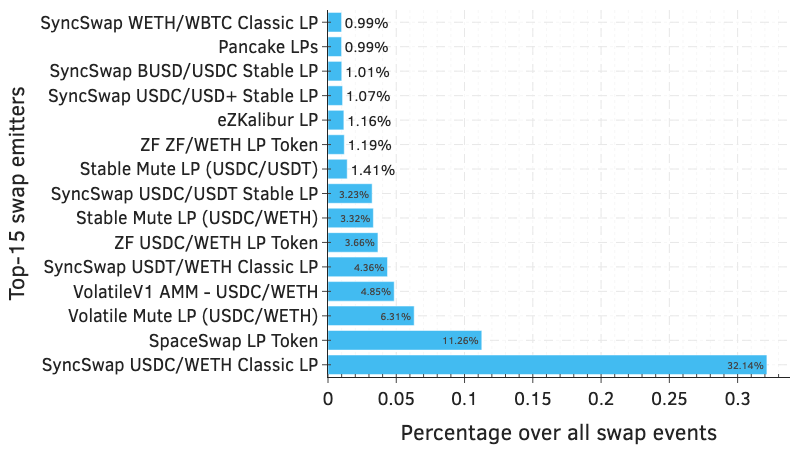

In [20]:
top_emitters = emitters_df[emitters_df["name"]!="Unknown"].iloc[:15]

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(y=top_emitters['name'], 
           x=top_emitters['swap_perc'],
           text=top_emitters['swap_perc'], 
           texttemplate='%{text:.2%}', 
           marker_color=colors['blue'],
           orientation='h'))
fig.update_layout(yaxis_title="Top-15 swap emitters",xaxis_title="Percentage over all swap events")
fig.write_image(os.path.join(plots_dir,'top-swap-emitters.pdf'))
fig.show('png')

## Top swappers (i.e. receivers)

In [21]:
swappers_df = (
    swap_lazy_df
    .group_by("receiver")
    .agg(pl.len().alias("swap_count"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values("swap_count", ascending=False)
)
swappers_df["swap_perc"] = swappers_df["swap_count"]/swappers_df["swap_count"].sum()
swappers_df.head()

,receiver,swap_count,swap_perc
1931966,0x8b791913eb07c32779a16750e3868aa8495f5964,2866796,0.041589
1501654,0xbe7d1fd1f6748bbdefc4fbacafbb11c6fc506d1d,2564423,0.037203
2703046,0x4bba932e9792a2b917d47830c93a9bc79320e4f7,1420258,0.020604
2699392,0x18381c0f738146fb694de18d1106bde2be040fa4,1315372,0.019082
2422578,0xa9305c3c14757bae2e73ef7f66fe241f5f6bf347,1064263,0.015439


In [22]:
len(swappers_df)

3822445

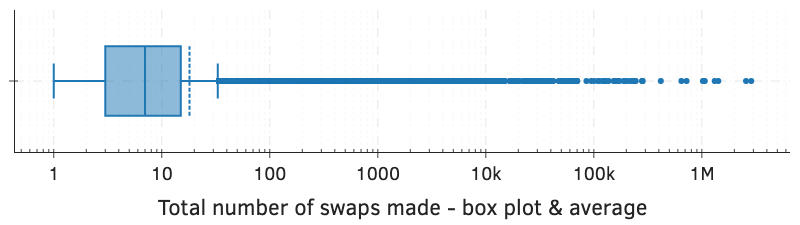

In [23]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height*0.5))
fig.add_trace(go.Box(x=swappers_df['swap_count'], boxmean=True, name=""))
fig.update_layout(xaxis_title="Total number of swaps made - box plot & average")
fig.update_xaxes(type="log")

fig.write_image(os.path.join(plots_dir,'swaps-by-swapper-dist.pdf'))
fig.show('png')

In [30]:
swappers_df['swap_count'].quantile([.25, .5, .75, 0.95])

0.25     3.0
0.50     7.0
0.75    15.0
0.95    42.0
Name: swap_count, dtype: float64

## Top swapping protocols (i.e. senders)

In [24]:
sender_df = (
    swap_lazy_df
    .group_by("sender")
    .agg(pl.len().alias("swap_count"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values("swap_count", ascending=False)
)
sender_df["swap_perc"] = sender_df["swap_count"]/sender_df["swap_count"].sum()
sender_df.head(10)

,sender,swap_count,swap_perc
94,0x2da10a1e27bf85cedd8ffb1abbe97e53391c0295,32442037,0.470643
180,0x8b791913eb07c32779a16750e3868aa8495f5964,9055905,0.131376
122,0xbe7d1fd1f6748bbdefc4fbacafbb11c6fc506d1d,6728082,0.097606
319,0x9b5def958d0f3b6955cbea4d5b7809b2fb26b059,4736592,0.068715
268,0x18381c0f738146fb694de18d1106bde2be040fa4,3582864,0.051977
29,0xd999e16e68476bc749a28fc14a0c3b6d7073f50c,1791260,0.025986
137,0xde759b830e1bf7116b6189f98b5c3a4f5fb8b59b,1173605,0.017026
150,0x6c31035d62541ceba2ac587ea09891d1645d6d07,857422,0.012439
300,0x498f7bb59c61307de7dea005877220e4406470e9,632189,0.009171
363,0x82b6960fd11b11e3bbf62bb5aeb5cffd63b468de,515912,0.007484


In [25]:
len(sender_df)

452

In [26]:
sender_df.tail(10)

,sender,swap_count,swap_perc
12,0x61d846c15475d45d6e5d5e18edf2dc54ff864618,1,1.450720e-08
92,0x73f96cfc901c5adeaa33a33fdebcebbcbb773b3c,1,1.450720e-08
286,0x3dc0d6ae67bdf685e491946dab0d2fb1a06c6c6a,1,1.450720e-08
59,0xaa39a07722f5933b2c99da08f09511a65365b193,1,1.450720e-08
203,0x2473e0965a111b2babd6c2004165a32b53ca756e,1,1.450720e-08
383,0x1b5c9b6dc4d8baca3a4492b6ec9d5f09c0c813fe,1,1.450720e-08
87,0xd9318ed5830a43038c000220777ca72b503c7752,1,1.450720e-08
398,0xa5af8dc3e725626359ef5918253141f19147a04e,1,1.450720e-08
309,0x13f1a70b3998d4451d5cd6ae5aaaf882472d962a,1,1.450720e-08
321,0x41ed56dd4736effbf3302ae301d70294ab8a23d6,1,1.450720e-08


## Swap events during a gas usage peak

In a previous [notebook](./02-data-exploration-fees.ipynb), we noticed three spikes in gas usage and looked into the contracts that were generating those spikes. In May 2023, the address receiving the most gas units was the SyncSwap router contract. In this section, we will look into this contract and check which tokens were the most traded during this time.

In [27]:
may_2023_hash_emitters_df = (
    swap_lazy_df
    .filter(pl.col('day').is_between(datetime(2023, 5, 1), datetime(2023, 5, 30)))
    .group_by("contract_address")
    .agg(pl.len().alias("swap_count"))
    .collect(streaming=True)
    .to_pandas()
    .merge(contract_map_df[["l2Address", "name", "symbol"]], how="left", left_on="contract_address", right_on="l2Address")
    .fillna({"name":"Unknown", "symbol":"Unknown"})
    .drop(columns=["l2Address"])
    .sort_values("swap_count", ascending=False)
)

In [28]:
may_2023_df = (
    may_2023_hash_emitters_df
    .groupby(["name", "symbol"])
    ["swap_count"]
    .sum()
    .reset_index()
    .sort_values("swap_count", ascending=False)
)
may_2023_df["swap_perc"] = may_2023_df["swap_count"]/may_2023_df["swap_count"].sum()
may_2023_df.head(10)

,name,symbol,swap_count,swap_perc
155,SyncSwap USDC/WETH Classic LP,USDC/WETH cSLP,1564536,0.478647
12,SpaceSwap LP Token,SLP,297142,0.090906
288,SyncSwap ZAT/WETH Classic LP,ZAT/WETH cSLP,264802,0.081012
337,Volatile Mute LP (USDC/WETH),vMLP (USDC/WETH),254493,0.077858
157,SyncSwap USDC/ZAT Classic LP,USDC/ZAT cSLP,97034,0.029686
200,SyncSwap WETH/Cheems Classic LP,WETH/Cheems cSLP,93984,0.028753
412,VolatileV1 AMM - USDC/WETH,vAMM-USDC/WETH,78122,0.023900
20,Stable Mute LP (USDC/WETH),sMLP (USDC/WETH),61659,0.018864
62,SyncSwap BUSD/USDC Stable LP,BUSD/USDC sSLP,57986,0.017740
205,SyncSwap WETH/DOGERA Classic LP,WETH/DOGERA cSLP,56230,0.017203
